In [1]:
import pandas as pd
import tarfile
from tqdm import tqdm
import json
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertModel
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2022-12-14 22:51:32.934028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 22:51:37.168277: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-14 22:51:42.869432: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:51:42.869697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
numpyArray = np.load('../Jiro/features.npy')
np.load = np_load_old
ratings_ = df = pd.DataFrame(numpyArray, columns = ['user_id','business_id','stars','text'])


In [3]:
ratingsnew = ratings_.head(10000)
# ratingsnew["stars"].astype(float).round()

for count in range(len(ratingsnew.text)):
    ratingsnew.at[count, 'text'] = " ".join(ratingsnew.at[count, 'text'])

# for tail 10k records, uncomment below:
# ratingsnew = ratings_.tail(10000)
# for count in range(40000, 49999):
#    ratingsnew.at[count, 'text'] = " ".join(ratingsnew.at[count, 'text'])

ratingsnew['text'] = ratingsnew['text'].astype(str)
print(ratings_.head(1))

                  user_id             business_id stars  \
0  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   3.0   

                                                text  
0  [CLS] If you decide to eat here , just be awar...  


In [6]:
df_features = ratingsnew
df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


/tmp/ipykernel_5073/2687010449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
/tmp/ipykernel_5073/2687010449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


In [7]:
train_df, test_df = train_test_split(df_features, test_size = 0.2)

y_train = tf.convert_to_tensor(train_df["stars"],dtype = "float")
y_test = tf.convert_to_tensor(test_df["stars"],dtype = "float")




2022-12-14 22:53:26.165750: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-14 22:53:26.165858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hcpu): /proc/driver/nvidia/version does not exist
2022-12-14 22:53:26.194094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
distilBert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [9]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [10]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [11]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [12]:
max_len = 512
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = distilBert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(20,activation = 'linear')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = False

In [13]:
optimizer = Adam(
    learning_rate=5e-05, 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = MeanSquaredError()
metric = MeanSquaredError()
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [MeanSquaredError(),MeanAbsolutePercentageError()])

In [14]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2
223/223 [==============================] - 197s 854ms/step - loss: 9.7453 - mean_squared_error: 9.7339 - mean_absolute_percentage_error: 71.1183 - val_loss: 5.6106 - val_mean_squared_error: 5.6047 - val_mean_absolute_percentage_error: 57.6575
Epoch 2/2
223/223 [==============================] - 188s 845ms/step - loss: 4.3968 - mean_squared_error: 4.3966 - mean_absolute_percentage_error: 56.5525 - val_loss: 3.1407 - val_mean_squared_error: 3.1380 - val_mean_absolute_percentage_error: 53.7266


In [15]:
predicted_raw = model.predict({'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']})
predicted_raw[0]

250/250 [==============================] - 135s 537ms/step


array([2.0945659, 2.3893669, 3.5206835, 3.891736 , 1.6446259, 3.3420794,
       3.3894663, 3.9177492, 4.388084 , 2.4338765, 3.062763 , 1.7051337,
       4.179069 , 2.3325908, 3.9010484, 3.3236291, 3.2478073, 3.4096694,
       4.1034675, 2.7179728], dtype=float32)

In [16]:
y_train[0]

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [17]:
train_history.history

{'loss': [9.745309829711914, 4.396796703338623],
 'mean_squared_error': [9.73388385772705, 4.396632671356201],
 'mean_absolute_percentage_error': [71.11827850341797, 56.55245590209961],
 'val_loss': [5.610601425170898, 3.1406726837158203],
 'val_mean_squared_error': [5.604659080505371, 3.1380412578582764],
 'val_mean_absolute_percentage_error': [57.657501220703125,
  53.726619720458984]}

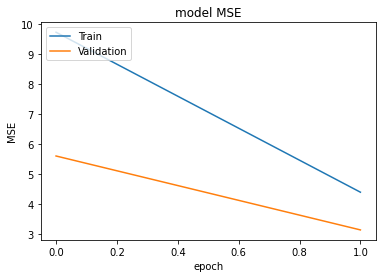

In [18]:
plt.plot(train_history.history['mean_squared_error'])
plt.plot(train_history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()